<a href="https://colab.research.google.com/github/AadiLakshmiAvula/FMML-LABS-AND-ASSIGNMENTS/blob/main/FMML_Module_9(b)_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9(b): Convolutional Neural Networks Project

## Module coordinator: Kushagra Agarwal



<img src="https://hub.packtpub.com/wp-content/uploads/2018/04/iStock-851960058-696x464.jpg" width=850px/>

In this project, you will understand how you can perform emotion recognition using CNNs in a step-by-step manner. To make your task easier, we provide you the starter code for the project. It is expected that you should try to understand the project statement properly and perform the tasks in sequence. We will be using Pytorch framework for the implementation. You need to fill in the missing code parts to achieve a particular task. At the end, you will have a basic implementation ready for an emotion detection application.

Basic steps involved in Emotion Recognition:
- Face detection
- Building classifier
- Classifying emotions

We will use a popular FER2013 dataset for this project.

## Task 1: Explore the dataset
The dataset contains 48 x 48 grayscale facial images of faces.The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

<img src="https://www.researchgate.net/profile/Chaudhary-Aqdus/publication/349055345/figure/fig3/AS:987834383085568@1612529478973/FER-2013-sample-images-for-facial-emotion-recognition.jpg" width=650px/>

Import libraries

In [1]:
# We have imported the necessary packages here. Feel free to import anything more you need!
import torch
import torchvision
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dlib
import cv2
from PIL import Image

### Download and load dataset

In [2]:
!gdown https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
!unzip fer2013.csv.zip

Downloading...
From (original): https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
From (redirected): https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N&confirm=t&uuid=a3a39e66-26f2-4ddd-9aba-b1533bd231c3
To: /content/fer2013.csv.zip
100% 101M/101M [00:01<00:00, 64.3MB/s]
Archive:  fer2013.csv.zip
  inflating: fer2013.csv             


In [3]:
# Load the dataset csv using pandas package. It displays the data in tabular form
emotion_data = pd.read_csv('./fer2013.csv')
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [4]:
# Class dictionary for dataset
classes = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

### Visualize a few images from dataset

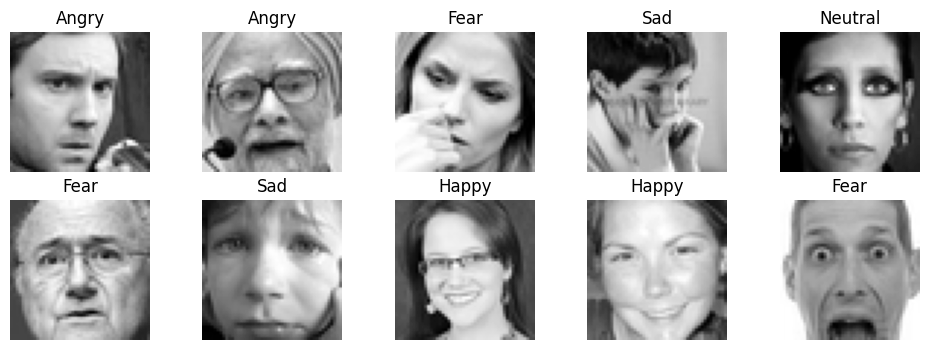

In [5]:
fig = plt.figure(figsize=(12,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  # This is how we access ith row in 'pixels' column in the dataset table
  img = emotion_data.iloc[i]['pixels'].split(' ') # Converting into array of ints
  img = np.array(img).astype(int)

  # Labels for our dataset
  label = int(emotion_data.iloc[i]['emotion'])
  ax.imshow(img.reshape((48,48)), cmap='gray')
  ax.set_title(classes[label])
  ax.set_axis_off()
plt.show()

In [6]:
names, counts = np.unique(emotion_data['Usage'].to_numpy(), return_counts=True)
print('Number of samples in {} = {}'.format(names[0], counts[0])) #testset
print('Number of samples in {} = {}'.format(names[1], counts[1])) #valset
print('Number of samples in {} = {}'.format(names[2], counts[2])) #trainset

Number of samples in PrivateTest = 3589
Number of samples in PublicTest = 3589
Number of samples in Training = 28709


### Distribution of class labels

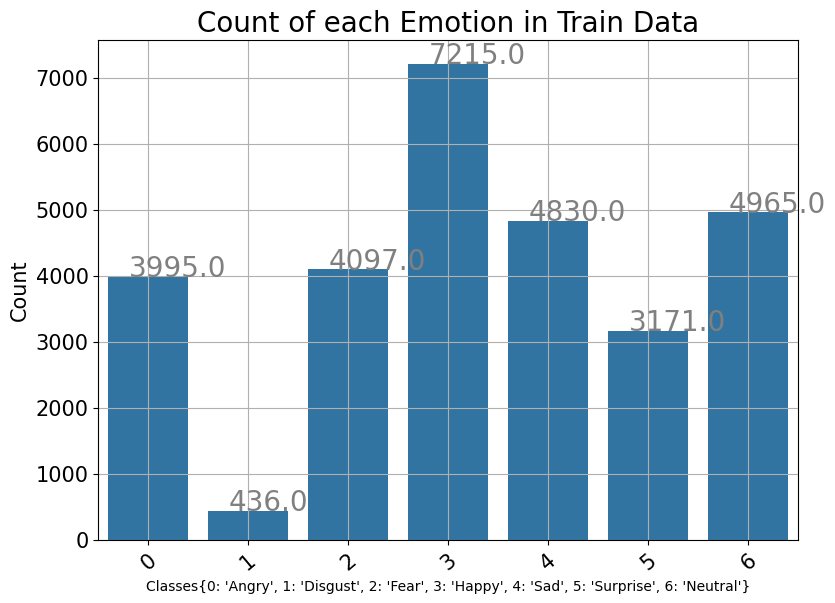

In [7]:
# Plot bar chart showing number of samples per class in the train set
temp_train = emotion_data.loc[emotion_data['Usage'] == 'Training']
df_temp_train = temp_train.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in Train Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_train)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

### Task: Similarly, write the code below to plot the charts for remaining two sets also.

Note the imbalance in the data through above graphs.

Face detection: Many applications involving facial images as input data require face detection in the pipeline at this step. Here, we localise the face in the given image removing the irrelevant parts, making the face centered and occupying most of the part in the image. As mentioned earlier, our dataset already has more or less centered faces, so we will skip this step for now but when using some other dataset or using your own images (eg. from webcam) as you will do later, you can do this step to get a proper cropped face from the image.

## Task 2: Data preprocessing

### Creating train, validation and test sets

In [8]:
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for index, row in emotion_data.iterrows():
  k = row['pixels'].split(" ")

  if row['Usage'] == 'Training':
    X_train.append(np.array(k))
    y_train.append(row['emotion'])

  # Similarly write the conditions for test and val splits here
  ###### YOUR CODE HERE  ######



X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape: ', X_train.shape, y_train.shape)
print('Validation set shape: ', X_val.shape, y_val.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (28709, 2304) (28709,)
Validation set shape:  (0,) (0,)
Testing set shape:  (0,) (0,)


In [9]:
# To get data between 0 and 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
X_val = X_val.astype(float) / 255.

We will define a dataset wrapper over Pytorch Dataset class which takes in the numpy arrays we created and returns a sample with required preprocessing.

In [10]:
class Fer2013Dataset(Dataset):
  def __init__(self, x, y, transforms=None):
    self.x = x.reshape((-1, 48, 48))
    self.y = y
    self.transforms= transforms

  def __getitem__(self, index):
    img, y = self.x[index], self.y[index]

    if self.transforms is not None:
        img = self.transforms(img)
    return img, y

  def __len__(self):
    return len(self.y)

In [11]:
batch_size=32

transform = transforms.ToTensor()

# Create tensor dataset from above tensors
train_dataset = Fer2013Dataset(X_train, y_train, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

val_dataset = Fer2013Dataset(X_val, y_val, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

test_dataset = Fer2013Dataset(X_test, y_test, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

## Task 3: Building a CNN model

In [12]:
# Define your CNN architecture here
# To start with, let's say you can create a model with 4 relu-activated convs,
# each followed by a pooling layer. Then, you can add 2-3 fully connected layers

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #### YOUR CODE HERE  ####

    def forward(self,x):
        #### YOUR CODE HERE  ####
        return x

In [13]:
# Device (CPU/GPU)
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the CNN
model = Net().to(device)
print(model)

Net()


### Training/Testing functions

In [14]:
def train(model, train_loader, loss_func, optimizer, num_epochs):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [15]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

## Task 4: Training & Evaluation

### Train the model

In [18]:
import math
import functools
import warnings
from collections import OrderedDict, defaultdict
from copy import deepcopy
from itertools import chain
from typing import (
    Any,
    Callable,
    DefaultDict,
    Dict,
    Hashable,
    Iterable,
    List,
    Optional,
    Set,
    Tuple,
    TypeVar,
    Union,
    cast,
    overload,
)
from typing_extensions import ParamSpec, Self, TypeAlias

import torch
import torch.utils.hooks as hooks
from torch.utils.hooks import RemovableHandle
from torch.utils._foreach_utils import (
    Indices,
    TensorListList,
    _get_foreach_kernels_supported_devices,
    _get_fused_kernels_supported_devices,
)
from torch._utils import is_compiling
from torch.utils._foreach_utils import _group_tensors_by_device_and_dtype

Args: TypeAlias = Tuple[Any, ...]
Kwargs: TypeAlias = Dict[str, Any]
StateDict: TypeAlias = Dict[str, Any]

GlobalOptimizerPreHook: TypeAlias = Callable[["Optimizer", Args, Kwargs], Optional[Tuple[Args, Kwargs]]]
GlobalOptimizerPostHook: TypeAlias = Callable[["Optimizer", Args, Kwargs], None]

__all__ = ['Optimizer', 'register_optimizer_step_pre_hook', 'register_optimizer_step_post_hook']
_global_optimizer_pre_hooks: Dict[int, GlobalOptimizerPreHook] = OrderedDict()
_global_optimizer_post_hooks: Dict[int, GlobalOptimizerPostHook] = OrderedDict()
_foreach_supported_types = [torch.Tensor, torch.nn.parameter.Parameter]

class _RequiredParameter:
    """Singleton class representing a required parameter for an Optimizer."""
    def __repr__(self) -> str:
        return ""

required = _RequiredParameter()

In [19]:
def _use_grad_for_differentiable(func):
    def _use_grad(self, *args, **kwargs):
        import torch._dynamo
        prev_grad = torch.is_grad_enabled()
        try:
            # Note on graph break below:
            # we need to graph break to ensure that aot respects the no_grad annotation.
            # This is important for perf because without this, functionalization will generate an epilogue
            # which updates the mutated parameters of the optimizer which is *not* visible to inductor, as a result,
            # inductor will allocate for every parameter in the model, which is horrible.
            # With this, aot correctly sees that this is an inference graph, and functionalization will generate
            # an epilogue which is appended to the graph, which *is* visible to inductor, as a result, inductor sees that
            # step is in place and is able to avoid the extra allocation.
            # In the future, we will either 1) continue to graph break on backward, so this graph break does not matter
            # or 2) have a fully fused forward and backward graph, which will have no_grad by default, and we can remove this
            # graph break to allow the fully fused fwd-bwd-optimizer graph to be compiled.
            # see https://github.com/pytorch/pytorch/issues/104053
            torch.set_grad_enabled(self.defaults['differentiable'])
            torch._dynamo.graph_break()
            ret = func(self, *args, **kwargs)
        finally:
            torch._dynamo.graph_break()
            torch.set_grad_enabled(prev_grad)
        return ret
    functools.update_wrapper(_use_grad, func)
    return _use_grad

In [20]:
def _get_value(x):
    # item is significantly faster than a cpu tensor in eager mode
    if not torch.jit.is_scripting() and is_compiling():
        return x
    else:
        return x.item()

In [21]:
def _stack_if_compiling(x):
    if not torch.jit.is_scripting() and is_compiling():
        return torch.stack(x)
    else:
        return x

In [22]:
def _dispatch_sqrt(x: float):  # float annotation is needed because of torchscript type inference
    if not torch.jit.is_scripting() and isinstance(x, torch.Tensor):
        return x.sqrt()
    else:
        return math.sqrt(x)

In [23]:
# For any optimizer with a faster implementation, we attempt to default to the
# fastest + stablest whenever possible. For foreach, the requirements are to have
# native params all on CUDA. For fused, there's currently the additional requirement
# that the tensors' dtypes must be floating point. Neither alternative supports
# torch.jit.script nor differentiable, so we fall back to the single tensor
# implementation in those cases.
def _default_to_fused_or_foreach(params: List[torch.Tensor],
                                 differentiable: bool,
                                 use_fused: bool = False) -> Tuple[bool, bool]:
    if torch.jit.is_scripting() or differentiable:
        return False, False

    fused_supported_devices = _get_fused_kernels_supported_devices()
    foreach_supported_devices = _get_foreach_kernels_supported_devices()
    fused = use_fused and all(
        p is None or (type(p) in _foreach_supported_types and
                      p.device.type in fused_supported_devices and
                      torch.is_floating_point(p)) for p in params
    )
    foreach = not fused and all(
        p is None or (type(p) in _foreach_supported_types and
                      p.device.type in foreach_supported_devices) for p in params
    )
    return fused, foreach

def _view_as_real(params, *state_and_grads):
    for i, p in enumerate(params):
        if torch.is_complex(p):
            params[i] = torch.view_as_real(params[i])
            for s in state_and_grads:
                s[i] = torch.view_as_real(s[i])

# Common doc strings among optimizers
_foreach_doc = r"""foreach (bool, optional): whether foreach implementation of optimizer
            is used. If unspecified by the user (so foreach is None), we will try to use
            foreach over the for-loop implementation on CUDA, since it is usually
            significantly more performant. Note that the foreach implementation uses
            ~ sizeof(params) more peak memory than the for-loop version due to the intermediates
            being a tensorlist vs just one tensor. If memory is prohibitive, batch fewer
            parameters through the optimizer at a time or switch this flag to False (default: None)"""

_fused_doc = r"""fused (bool, optional): whether the fused implementation (CUDA only) is used.
            Currently, `torch.float64`, `torch.float32`, `torch.float16`, and `torch.bfloat16`
            are supported. (default: None)

    .. note:: The foreach and fused implementations are typically faster than the for-loop,
              single-tensor implementation. Thus, if the user has not specified BOTH flags
              (i.e., when foreach = fused = None), we will attempt defaulting to the foreach
              implementation when the tensors are all on CUDA. For example, if the user specifies
              True for fused but nothing for foreach, we will run the fused implementation. If
              the user specifies False for foreach but nothing for fused (or False for fused but
              nothing for foreach), we will run the for-loop implementation. If the user specifies
              True for both foreach and fused, we will prioritize fused over foreach, as it is
              typically faster. We attempt to use the fastest, so the hierarchy goes fused ->
              foreach -> for-loop. HOWEVER, since the fused implementation is relatively new,
              we want to give it sufficient bake-in time, so we default to foreach and NOT
              fused when the user has not specified either flag."""

_capturable_doc = r"""capturable (bool, optional): whether this instance is safe to
            capture in a CUDA graph. Passing True can impair ungraphed performance,
            so if you don't intend to graph capture this instance, leave it False
            (default: False)"""

_differentiable_doc = r"""differentiable (bool, optional): whether autograd should
            occur through the optimizer step in training. Otherwise, the step()
            function runs in a torch.no_grad() context. Setting to True can impair
            performance, so leave it False if you don't intend to run autograd
            through this instance (default: False)"""

_maximize_doc = r"""maximize (bool, optional): maximize the objective with respect to the
            params, instead of minimizing (default: False)"""


In [24]:
def register_optimizer_step_pre_hook(hook: GlobalOptimizerPreHook) -> RemovableHandle:
    r"""Register a pre hook common to all optimizers. The hook should have the following
    signature::

        hook(optimizer, args, kwargs) -> None or modified args and kwargs

    Args:
        hook (Callable): A user defined hook which is registered on all optimizers.

    Returns:
        :class:`torch.utils.hooks.RemovableHandle`:
            a handle that can be used to remove the added hook by calling
            ``handle.remove()``
    """
    handle = hooks.RemovableHandle(_global_optimizer_pre_hooks)
    _global_optimizer_pre_hooks[handle.id] = hook
    return handle

In [25]:
def register_optimizer_step_post_hook(hook: GlobalOptimizerPostHook) -> RemovableHandle:
    r"""Register a post hook common to all optimizers. The hook should have the following
    signature::

        hook(optimizer, args, kwargs) -> None

    Args:
        hook (Callable): A user defined hook which is registered on all optimizers.

    Returns:
        :class:`torch.utils.hooks.RemovableHandle`:
            a handle that can be used to remove the added hook by calling
            ``handle.remove()``
    """
    handle = hooks.RemovableHandle(_global_optimizer_post_hooks)
    _global_optimizer_post_hooks[handle.id] = hook
    return handle

ParamsT: TypeAlias = Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]]

_P = ParamSpec("_P")
R = TypeVar("R")
T = TypeVar("T")


class Optimizer:
    r"""Base class for all optimizers.

    .. warning::
        Parameters need to be specified as collections that have a deterministic
        ordering that is consistent between runs. Examples of objects that don't
        satisfy those properties are sets and iterators over values of dictionaries.

    Args:
        params (iterable): an iterable of :class:`torch.Tensor` s or
            :class:`dict` s. Specifies what Tensors should be optimized.
        defaults: (dict): a dict containing default values of optimization
            options (used when a parameter group doesn't specify them).
    """

    OptimizerPreHook: TypeAlias = Callable[[Self, Args, Kwargs], Optional[Tuple[Args, Kwargs]]]  # type: ignore[misc]
    OptimizerPostHook: TypeAlias = Callable[[Self, Args, Kwargs], None]  # type: ignore[misc]

    _optimizer_step_pre_hooks: Dict[int, OptimizerPreHook]
    _optimizer_step_post_hooks: Dict[int, OptimizerPostHook]
    _optimizer_state_dict_pre_hooks: 'OrderedDict[int, Callable[["Optimizer"], None]]'
    _optimizer_state_dict_post_hooks: 'OrderedDict[int, Callable[["Optimizer", StateDict], Optional[StateDict]]]'
    _optimizer_load_state_dict_pre_hooks: 'OrderedDict[int, Callable[["Optimizer", StateDict], Optional[StateDict]]]'
    _optimizer_load_state_dict_post_hooks: 'OrderedDict[int, Callable[["Optimizer"], None]]'


In [26]:
def __init__(self, params: ParamsT, defaults: Dict[str, Any]) -> None:
        torch._C._log_api_usage_once("python.optimizer")
        self.defaults = defaults
        self._optimizer_step_pre_hooks = OrderedDict()
        self._optimizer_step_post_hooks = OrderedDict()
        self._optimizer_state_dict_pre_hooks = OrderedDict()
        self._optimizer_state_dict_post_hooks = OrderedDict()
        self._optimizer_load_state_dict_pre_hooks = OrderedDict()
        self._optimizer_load_state_dict_post_hooks = OrderedDict()

        self._patch_step_function()

        if isinstance(params, torch.Tensor):
            if self.__class__.__name__ == 'SparseAdam':
                warnings.warn(("Passing in a raw Tensor as ``params`` to SparseAdam "
                               "is deprecated. In the future, this will raise an error. "
                               "Please wrap your Tensor in an iterable instead."),
                              FutureWarning)
            else:
                raise TypeError("params argument given to the optimizer should be "
                                "an iterable of Tensors or dicts, but got " +
                                torch.typename(params))

        self.state: DefaultDict[torch.Tensor, Any] = defaultdict(dict)
        self.param_groups: List[Dict[str, Any]] = []

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError("optimizer got an empty parameter list")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(cast(dict, param_group))

        # Allows _cuda_graph_capture_health_check to rig a poor man's TORCH_WARN_ONCE in python,
        # which I don't think exists
        # https://github.com/pytorch/pytorch/issues/72948
        self._warned_capturable_if_run_uncaptured = True


In [27]:
def __getstate__(self) -> Dict[str, Any]:
        return {
            'defaults': self.defaults,
            'state': self.state,
            'param_groups': self.param_groups,
        }


In [28]:
def __setstate__(self, state: Dict[str, Any]) -> None:
        self.__dict__.update(state)
        if '_optimizer_step_pre_hooks' not in self.__dict__:
            self._optimizer_step_pre_hooks = OrderedDict()
        if '_optimizer_step_post_hooks' not in self.__dict__:
            self._optimizer_step_post_hooks = OrderedDict()
        if '_optimizer_state_dict_pre_hooks' not in self.__dict__:
            self._optimizer_state_dict_pre_hooks = OrderedDict()
        if '_optimizer_state_dict_post_hooks' not in self.__dict__:
            self._optimizer_state_dict_post_hooks = OrderedDict()
        if '_optimizer_load_state_dict_pre_hooks' not in self.__dict__:
            self._optimizer_load_state_dict_pre_hooks = OrderedDict()
        if '_optimizer_load_state_dict_post_hooks' not in self.__dict__:
            self._optimizer_load_state_dict_post_hooks = OrderedDict()
        self._patch_step_function()  # To support multiprocessing pickle/unpickle
        self.defaults.setdefault('differentiable', False)


In [29]:
 def __repr__(self) -> str:
        format_string = self.__class__.__name__ + ' ('
        for i, group in enumerate(self.param_groups):
            format_string += '\n'
            format_string += f'Parameter Group {i}\n'
            for key in sorted(group.keys()):
                if key != 'params':
                    format_string += f'    {key}: {group[key]}\n'
        format_string += ')'
        return format_string

In [31]:

    def _cuda_graph_capture_health_check(self) -> None:
        # Note [torch.compile x capturable]
        # If we are compiling, we try to take the capturable path automatically by
        # setting the flag to True during tracing. Due to this, we skip all the checks
        # normally required for determining whether we can use CUDA graphs and
        # shunt the responsibility to torch.inductor. This saves time during tracing
        # since the checks are slow without sacrificing UX since inductor will warn
        # later if CUDA graphs cannot be enabled, e.g.,
        # https://github.com/pytorch/pytorch/blob/d3ba8901d8640eb16f88b2bfef9df7fa383d4b47/torch/_inductor/compile_fx.py#L390.
        # Thus, when compiling, inductor will determine if cudagraphs
        # can be enabled based on whether there is input mutation or CPU tensors.
        if not is_compiling() and torch.backends.cuda.is_built() and torch.cuda.is_available():
            capturing = torch.cuda.is_current_stream_capturing()

            if capturing and not all(group['capturable'] for group in self.param_groups):
                raise RuntimeError("Attempting CUDA graph capture of step() for an instance of " +
                                   self.__class__.__name__ +
                                   " but param_groups' capturable is False.")

            if (
                (not getattr(self, "_warned_capturable_if_run_uncaptured", False))
                and all(group['capturable'] for group in self.param_groups)
                and (not capturing)
            ):
                warnings.warn(
                    "This instance was constructed with capturable=True or some of all the param_groups came with capturable=True, "
                    "but step() is running without CUDA graph capture. If you never intend to graph-capture this "
                    "instance, capturable=True can impair performance, and you should set capturable=False."
                )
                self._warned_capturable_if_run_uncaptured = True

In [36]:
def test_model(model, testloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  if total == 0:
    print("No predictions were made. Please check your data loading process.")
  else:
    print('Accuracy of the network: %d %%' % (
        100 * correct / total))



**BONUS** **TASK**

How can you improve the performance of your model given that the number of datapoints is fixed?

Hint: A very simple fix (discussed in Lab 2) is to use a pretrained CNN model. The pretrained model could be trained on any dataset (eg Imagenet) and the first few layers of the same can be directly used for this task.

You are encouraged to try out different pretrained models like ResNet/VGG/AlexNet and see how the performance improves. Do all the models result in similar accuracy?